In my previous work (https://github.com/morosow/hltb-analysis), I have written a parser to get data from the 'howlongtobeat.com' site. Today I will make a data frame from it, analyze information and set a machine learning goal.

    1. Data wrangling
        1.1. Importing libraries
        1.2. Checking data
        1.3. Deleting empty rows and duplicates
        1.4. Converting time to minutes
        1.5. Converting sample's number to integer value
    2. Data Analysis
        2.1. Developers overview
        2.2. Platforms overview
        2.3. Genres overview
        2.4. Games overview
    3. Machine learning models
        3.1. Problem recognition
        3.2. Walktroughs of main game prediction
            3.2.1. Model choosing
            3.2.2. Splitting data
            3.2.3. Learning of model
            3.2.4. Tuning parameters
            3.2.5. Final predictions on trainset
            3.2.6. Summarizing   
        3.3. Games clustering (in progress...)

### 1. Data wrangling

#### 1.1 Importing libraries

A ML-libraries will be imported in the relevant section. (see 3.3)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('final.csv', sep=';', header=0, skip_blank_lines=True, error_bad_lines=False)

b'Skipping line 40946: expected 51 fields, saw 99\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,15,20,25,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Only one bad line is not so good result.

#### 1.2. Checking data

Let's check how big our data set.

In [3]:
data.shape

(85024, 51)

So, 85 thousand records. It is really good and will help us when we will train our model.

In [4]:
print(data.columns)

Index(['Url', 'Title', 'Description', 'Developer', 'Publisher', 'Genres',
       'Playable On', 'Released in NA', 'Released in EU', 'Released in JP',
       'Main Story Polled', 'Main Story Average', 'Main Story Median',
       'Main Story Rushed', 'Main Story Leisure', 'Main + Extras Polled',
       'Main + Extras Average', 'Main + Extras Median', 'Main + Extras Rushed',
       'Main + Extras Leisure', 'Completionists Polled',
       'Completionists Average', 'Completionists Median',
       'Completionists Rushed', 'Completionists Leisure',
       'AllPlayStyles Polled', 'AllPlayStyles Average', 'AllPlayStyles Median',
       'AllPlayStyles Rushed', 'AllPlayStyles Leisure', 'Any% Polled',
       'Any% Average', 'Any% Median', 'Any% Fastest', 'Any% Slowest',
       '100% Polled', '100% Average', '100% Median', '100% Fastest',
       '100% Slowest', 'Co-Op Polled', 'Co-Op Average', 'Co-Op Median',
       'Co-Op Least', 'Co-Op Most', 'Competetive Polled',
       'Competetive Average', 'C

In [5]:
data.head()

,Url,Title,Description,Developer,Publisher,Genres,Playable On,Released in NA,Released in EU,Released in JP,Main Story Polled,Main Story Average,Main Story Median,Main Story Rushed,Main Story Leisure,Main + Extras Polled,Main + Extras Average,Main + Extras Median,Main + Extras Rushed,Main + Extras Leisure,Completionists Polled,Completionists Average,Completionists Median,Completionists Rushed,Completionists Leisure,AllPlayStyles Polled,AllPlayStyles Average,AllPlayStyles Median,AllPlayStyles Rushed,AllPlayStyles Leisure,Any% Polled,Any% Average,Any% Median,Any% Fastest,Any% Slowest,100% Polled,100% Average,100% Median,100% Fastest,100% Slowest,Co-Op Polled,Co-Op Average,Co-Op Median,Co-Op Least,Co-Op Most,Competetive Polled,Competetive Average,Competetive Median,Competetive Least,Competetive Most,Unnamed: 50
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://howlongtobeat.com/game.php?id=1,688(I) Hunter/Killer,"688(I) Hunter/Killer, the most realistic subma...",Sonalysts,Electronic Arts,NaN,PC,"July 04, 1997",NaN,NaN,6,9h 10m,9h 34m,6h 26m,11h 36m,5,35h 22m,13h,14h 05m,72h 30m,2,15h 50m,15h 50m,10h 15m,21h 25m,13,20h 16m,11h 01m,9h 34m,68h 14m,1.0,7h 55m 44s,7h 55m 44s,7h 55m 44s,7h 55m 44s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://howlongtobeat.com/game.php?id=2,Beyond Good & Evil 2,NaN,Ubisoft Montpellier,Ubisoft,"Action, Adventure",NaN,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Quite a lot of cells are empty, but it needs to see the whole picture.

In [6]:
data.info(memory_usage = 'deep', verbose = 'True')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85024 entries, 0 to 85023
Data columns (total 51 columns):
Url                       74318 non-null object
Title                     74316 non-null object
Description               38815 non-null object
Developer                 42681 non-null object
Publisher                 40865 non-null object
Genres                    19337 non-null object
Playable On               26613 non-null object
Released in NA            39790 non-null object
Released in EU            16868 non-null object
Released in JP            6609 non-null object
Main Story Polled         22563 non-null object
Main Story Average        22559 non-null object
Main Story Median         22559 non-null object
Main Story Rushed         22559 non-null object
Main Story Leisure        22560 non-null object
Main + Extras Polled      14842 non-null object
Main + Extras Average     14841 non-null object
Main + Extras Median      14840 non-null object
Main + Extras Rushed      14

There are not so many fields with more than 10 000 records. As first we need to clean our data.

#### 1.3. Deleting empty rows and duplicates

Delete incorrect column and first row.

In [0]:
data = data.drop(['Unnamed: 50'], axis = 1)
data = data.drop([0], axis = 0)

Also, duplicates and reindex out df.

In [0]:
data.drop_duplicates(keep = 'first', inplace=True)
data.set_index(np.arange(0, data.shape[0]), inplace = True)

#### 1.4. Converting time to minutes

Now our time is in form like "hh mm ss". Of course, it needs to be converted into float format.

I have chosen hours to avoid large values in the cell.

In [0]:
def time_convert(columnNumber):
    rowsCounter = 0

    for time in data.iloc[:, columnNumber]:
        if time == time:
            if len(time) > 0:
                if time.find('h') > 0:
                    if time.find('m') > 0:
                        if time.find('s') > 0:  # hours, minutes,seconds
                            data.iloc[rowsCounter, columnNumber] = int(time[0:time.find('h')]) + int(
                                time[time.find('m') - 2:time.find('m')]) / 60 + int(
                                time[time.find('s') - 3:time.find('s')]) / 3600
                        else:  # hours and minutes
                            data.iloc[rowsCounter, columnNumber] = int(time[0:time.find('h')]) + int(time[-4:-2]) / 60
                    elif time.find('s') > 0:  # hours and seconds
                        data.iloc[rowsCounter, columnNumber] = int(time[0:time.find('h')]) + int(time[-4:-2]) / 3600
                    else:  # only hours
                        data.iloc[rowsCounter, columnNumber] = int(time[:-2])
                else:
                    if time.find('m') > 0:
                        if time.find('s') > 0:  # minutes and seconds
                            data.iloc[rowsCounter, columnNumber] = int(time[0:time.find('m')]) / 60 + int(
                                time[-4:-2]) / 3600
                        else:  # only minutes
                            data.iloc[rowsCounter, columnNumber] = int(time[0:2]) / 60
                    else:
                        if time.find('s') > 0:  # only seconds
                            data.iloc[rowsCounter, columnNumber] = int(time[0:2]) / 3600
                        else:  # unexpected value
                            data.iloc[rowsCounter, columnNumber] = 0
        rowsCounter += 1

Although our function replaces the data, we just need to run it once for all columns in the same format. There are 32 such columns in df.

In [0]:
timeIndexes = [11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42,
               43, 44, 46, 47, 48, 49]


for row in timeIndexes:
    time_convert(row)

Another type of abbreviation is 'k' as a thousand. Write the function...

In [0]:
def polled_convert(columnNumber):
    for row in range(data.shape[0]):
        if data.iloc[row, columnNumber] == data.iloc[row, columnNumber]:
            if str(data.iloc[row, columnNumber]).find('K') > 0:  # 1K = 1000
                try:
                    data.iloc[row, columnNumber] = int(float(data.iloc[row, columnNumber][:-2]) * 1000)
                except Exception as e:
                    print(e)

#### 1.5. Converting sample's number to integer value

...and finally convert it.

In [12]:
polledIndexes = [10, 15, 20, 25, 30, 35, 40, 45]

# Converting k-values to integer
for row in polledIndexes:
    polled_convert(row)

could not convert string to float: '1K'


### 2. Data Analysis

And now, when our data are prepared we can analyze it.
As first we need to identify main features. 

For videogames, it's: *developer*, *platform* and *genre*.
And finally, we need to overview the situation on the market.

#### 2.1. Developers overview

Of course, our main question - how many developers exist in our data?

In [13]:
print(data['Developer'].nunique())

17229


Nice, but is does not developers. It is non-empty strings because in one string might be several developers.

In [0]:
# Getting developers list
developers_list = []

for elem in data['Developer']:
    if elem not in developers_list:
        developers_list.append(elem)

We added all these values ​​in a list. Now we need to split it, convert into a normal state and delete duplicates.

In [0]:
# Getting list of all developers 
developers = []
for dev in developers_list:
    if isinstance(dev, str):
        devsInString = 0
        while devsInString < len(dev.split(sep=',')):
            developers.append(dev.split(sep=',')[devsInString])
            devsInString += 1

# Deleting spaces             
counter = 0
for devs in developers:
    if devs[0] == ' ':
        developers[counter] = devs[1:]
    counter += 1

# Deleting duplicates
developers = list(dict.fromkeys(developers))

for dev in developers:
    if isinstance(dev, str):
        if len(dev) < 5:
            developers.remove(dev)

Now, when we get the developers' list, let's count how much game do they made.

In [0]:
# Count games for every developer

developersDict = {}
for dev in developers:
    if isinstance(dev, str):
        counter = 0
        for devsInString in data['Developer']:
            if isinstance(devsInString, str):
                if devsInString.find(dev) > 0 or devsInString == dev:
                    counter += 1
        developersDict[dev] = counter

And convert in into dataframe.

In [0]:
dev_df = pd.DataFrame(columns=['Developer', 'Games'])

for key, value in developersDict.items():
    dev_df = dev_df.append({'Developer': key, 'Games': value}, 
                           ignore_index=True)

Now we get a dataframe with developers and a number of their games. We only need to clean this data.

In [0]:
dev_df.drop_duplicates(keep='first', inplace=True)
dev_df.set_index(np.arange(0, dev_df.shape[0]), inplace=True)

In [19]:
dev_df[dev_df['Games'] >= 50].sort_values(by='Games', ascending=False)[:]

,Developer,Games
9239,Production,566
173,Konami,380
23,Capcom,322
5148,Game Studio,217
99,Namco,197
317,Nintendo,140
6155,Vision,138
439,Telltale Games,135
14874,Montreal,120
127,Hudson Soft,118


In [0]:
# Deleting incorrect values - 'Studio', 'Inc', 'Ltd', 'Inc' and so on...

dev_df = dev_df.drop(5433,axis = 0)
dev_df = dev_df.drop(9859,axis = 0)
dev_df = dev_df.drop(1209,axis = 0)
dev_df = dev_df.drop(3790,axis = 0)
dev_df = dev_df.drop(6199,axis = 0)
dev_df = dev_df.drop(8331,axis = 0)
dev_df = dev_df.drop(8257,axis = 0)

dev_df.set_index(np.arange(0, dev_df.shape[0]), inplace=True)

Super! I will not create an accurate graph, but we can see the basic statistics based on this data.

In [22]:
# Developers, that create at least one game.
non_zero = dev_df[dev_df['Games'] > 0]['Games'].count()


print('Developed more than:')
print('1 games:', '\t{0:8.2f}%'.format((dev_df[dev_df['Games'] > 1]
                                        ['Games'].count()) * 100 / non_zero))
print('3 games:', '\t{0:8.2f}%'.format((dev_df[dev_df['Games'] > 3]
                                        ['Games'].count()) * 100 / non_zero))
print('4 games:', '\t{0:8.2f}%'.format((dev_df[dev_df['Games'] > 4]
                                        ['Games'].count()) * 100 / non_zero))
print('5 games:', '\t{0:8.2f}%'.format((dev_df[dev_df['Games'] > 5]
                                        ['Games'].count()) * 100 / non_zero))
print('15 games:', '\t{0:8.2f}%'.format((dev_df[dev_df['Games'] > 15]
                                         ['Games'].count()) * 100 / non_zero))

Developed more than:
1 games: 	   31.74%
3 games: 	   12.16%
4 games: 	    9.14%
5 games: 	    7.03%
15 games: 	    1.74%


Wow! 68.27% of developers have created only one game. Yes, the market is hard. But I have one funny fact:

In [23]:
gameCounter = 0
studioCounter = 0

for developer in dev_df['Developer']:
    try:
        if developer.lower().find('game') > 0:
            gameCounter += 1
        if developer.lower().find('studio') > 0:
            studioCounter += 1
    except:
        pass

print(gameCounter, 'developers has "game" in studio\'s name.')
print('It is', '{0:2.2f}% of all game studios.'.format(gameCounter * 100 / dev_df.shape[0]))
print('=' * 50)
print(studioCounter, 'developers has "studio" in studio\'s name.')
print('It is', '{0:2.2f}% of all game studios.'.format(studioCounter * 100 / dev_df.shape[0]))

2958 developers has "game" in studio's name.
It is 17.77% of all game studios.
1863 developers has "studio" in studio's name.
It is 11.19% of all game studios.


#### 2.2. Platforms overview

Ok, Whats about a platforms? As first, let's count them.

In [24]:
platforms = []

for row in data['Playable On']:
    if row == row:
        for platform in row.split(sep=','):
            if (platform not in platforms) and len(platform) > 0:
                platforms.append(platform)

for i in range(0, len(platforms)):
    if platforms[i][0] == ' ':
        platforms[i] = platforms[i][1:]
    i += 1

platforms = list(dict.fromkeys(platforms))
print(len(platforms))
platforms.sort()

77


So we have 77 videogame platforms! Which is most popular?

In [25]:
platforms_dict = {}

for platform in platforms:
    count = 0
    for row in data['Playable On']:
        if row == row:
            for elem in row.split(sep=','):
                if elem.find(platform) >= 0:
                    count += 1
    platforms_dict[platform] = count

gamesSum = 0
for value in platforms_dict.values():
    gamesSum += value

print('Platform', ' ' * 18, '%', ' ' * 6, 'Released Games')
print('===============================================')
for key, value in sorted(platforms_dict.items(), key=lambda x: x[1], reverse=True):
    print(key, ' ' * (25 - len(key)), '{0:.2f}'.format(100 * value / gamesSum), '\t', value)

Platform                    %        Released Games
PC                         31.23 	 14525
PlayStation                15.55 	 7233
Xbox                       8.26 	 3843
PlayStation 4              4.38 	 2036
PlayStation 3              4.12 	 1915
Xbox 360                   3.92 	 1825
Xbox One                   3.28 	 1524
PlayStation 2              3.24 	 1508
Wii                        2.38 	 1106
Game Boy                   2.09 	 970
Nintendo Switch            2.02 	 940
Nintendo 3DS               1.71 	 795
PlayStation Vita           1.64 	 762
Mobile                     1.58 	 734
Nintendo DS                1.51 	 701
PSP                        1.34 	 622
Super Nintendo             1.24 	 575
NES                        1.20 	 556
Game Boy Advance           1.12 	 519
Sega Mega Drive/Genesis    1.05 	 487
Nintendo GameCube          0.93 	 433
Wii U                      0.89 	 416
Arcade                     0.77 	 356
Nintendo 64                0.49 	 226
Browser                 

Of course, this is a site's data and not absolutely correct. But we can say that ~ 31.23% are PC-games, 29% were available on Playstation, 15.5% on Xbox and last 25% - on other platforms.

#### 2.3. Genres overview

The situation with genres is not so simple as with platforms. But, as first let's read all genres to a list and clean data.

In [0]:
# Converting genres to list and inserting into cells
counter = 0
for row in data['Genres']:
    if not pd.isnull(row):
        data.iat[counter, 5] = row.split(sep=',')
    counter += 1

Now i have 230+ genres, most of them are the same. They may have similar spelling or just grammar errors. There is only one way to refactor genres in this situation without neuro network - make it manually.

Ok, I did it. Time to transform it into our data.

In [0]:
counter = 0
for row in data['Genres']:
    if row == row:
        i = 0
        while i < len(row):

            if (row[i].lower().find('2.5d platform game') >= 0) or (
                row[i].lower().find('2.5d platformer') >= 0):
                data['Genres'].loc[counter][i] = '2.5d platformer'
            if (row[i].lower().find('breakout clone') >= 0) or (
                row[i].lower().find('breakout') >= 0):
                data['Genres'].loc[counter][i] = 'breakout'
            if (row[i].lower().find("shoot 'em up") >= 0) or (
                row[i].lower().find("shoot em' up") >= 0) or (
                    row[i].lower().find('shoot-em-up') >= 0):
                data['Genres'].loc[counter][i] = "shoot 'em up"
            if (row[i].lower().find('city-builder') >= 0) or (
                row[i].lower().find('city-building') >= 0) or (
                    row[i].lower().find('city-building game') >= 0):
                data['Genres'].loc[counter][i] = 'city-building'
            if (row[i].lower().find("hack 'n' slash") >= 0) or (
                row[i].lower().find('hack and slash') >= 0) or (
                    row[i].lower().find('hack-and-slash') >= 0):
                data['Genres'].loc[counter][i] = 'hack and slash'
            if (row[i].lower().find('point and click') >= 0) or (
                row[i].lower().find('point-and-click') >= 0) or (
                    row[i].lower().find('point-and-click adventure') >= 0):
                data['Genres'].loc[counter][i] = 'point and click'
            if (row[i].lower().find('strategy rpg') >= 0) or (
                row[i].lower().find('dramatic/innovative rpg') >= 0) or (
                    row[i].lower().find('action rpg') >= 0) or (
                        row[i].lower().find('action role-playing') >= 0) or (
                    row[i].lower().find('computer role-playing game') >= 0) or (
                    row[i].lower().find('computer role-playing') >= 0) or (
                    row[i].lower().find('role playing') >= 0) or (
                        row[i].lower().find('role-playing') >= 0) or (
                    row[i].lower().find('role-playing game') >= 0) or (
                        row[i].lower().find('rpg') >= 0):
                data['Genres'].loc[counter][i] = 'rpg'
            if (row[i].lower().find('tactical action') >= 0) or (row[i].lower().find('tactical role-playing') >= 0) or (
                    row[i].lower().find('tactical role-playing game') >= 0) or (
                    row[i].lower().find('tactical rpg') >= 0) or (row[i].lower().find('tactical shooter') >= 0) or (
                    row[i].lower().find('tactics') >= 0) or (row[i].lower().find('tactical') >= 0):
                data['Genres'].loc[counter][i] = 'tactical'
            if (row[i].lower().find('artillery') >= 0) or (row[i].lower().find('artillery game') >= 0):
                data['Genres'].loc[counter][i] = 'artillery'
            if (row[i].lower().find('mecha') >= 0) or (row[i].lower().find('mech simulator') >= 0) or (
                    row[i].lower().find('mecha simulation') >= 0) or (
                    row[i].lower().find('mecha simulation game') >= 0):
                data['Genres'].loc[counter][i] = 'mecha simulation'
            if (row[i].lower().find('platform') >= 0) or (row[i].lower().find('platform game') >= 0) or (
                    row[i].lower().find('platformer') >= 0) or (row[i].lower().find('platforming') >= 0):
                data['Genres'].loc[counter][i] = 'platformer'
            if (row[i].lower().find('puzzle') >= 0) or (row[i].lower().find('puzzle game') >= 0) or (
                    row[i].lower().find('puzzle/platform') >= 0) or (row[i].lower().find('puzzles') >= 0):
                data['Genres'].loc[counter][i] = 'puzzle'
            if (row[i].lower().find('scrolling shooter') >= 0) or (row[i].lower().find('scrolling') >= 0) or (
                    row[i].lower().find('strategy side-scroller') >= 0) or (row[i].lower().find('side') >= 0) or (
                    row[i].lower().find('side scrolling') >= 0) or (row[i].lower().find('side-scroller') >= 0) or (
                    row[i].lower().find('side-scrolling') >= 0) or (
                    row[i].lower().find('side-scrolling platform') >= 0) or (row[i].lower().find('sidescroller') >= 0):
                data['Genres'].loc[counter][i] = 'side-scrolling'
            if (row[i].lower().find('stealth') >= 0) or (row[i].lower().find('stealth action') >= 0) or (
                    row[i].lower().find('stealth game') >= 0) or (row[i].lower().find('stealth-based game') >= 0):
                data['Genres'].loc[counter][i] = 'stealth'
            if (row[i].lower().find('medieval / fantasy') >= 0) or (
                    row[i].lower().find('medieval fantasy action') >= 0):
                data['Genres'].loc[counter][i] = 'medival'
            if (row[i].lower().find('tbs') >= 0) or (row[i].lower().find('turn-based tactical') >= 0) or (
                    row[i].lower().find('turn-based tactics') >= 0) or (row[i].lower().find('turn-based') >= 0) or (
                    row[i].lower().find('turn-based strategy') >= 0):
                data['Genres'].loc[counter][i] = 'turn-based'
            if (row[i].lower().find('light gun') >= 0) or (row[i].lower().find('light gun shooter') >= 0) or (
                    row[i].lower().find('light-gun shooter') >= 0):
                data['Genres'].loc[counter][i] = 'light gun'
            if (row[i].lower().find('combat flight simulator') >= 0) or (
                    row[i].lower().find('flight simulator') >= 0) or (row[i].lower().find('flight') >= 0) or (
                    row[i].lower().find('flight combat') >= 0) or (row[i].lower().find('flight simulation') >= 0):
                data['Genres'].loc[counter][i] = 'flight'
            if (row[i].lower().find('first-person') >= 0) or (row[i].lower().find('first-person') >= 0) or (
                    row[i].lower().find('first-peson') >= 0) or (
                    row[i].lower().find('first-person adventure') >= 0) or (row[i].lower().find('first person') >= 0):
                data['Genres'].loc[counter][i] = 'first-person'
            if (row[i].lower().find('shoote') >= 0) or (
                row[i].lower().find('third person tactical shooter') >= 0) or (
                row[i].lower().find('third person shooter') >= 0) or (
                row[i].lower().find('third-person shooter') >= 0) or (
                row[i].lower().find('twin stick shooter') >= 0) or (
                row[i].lower().find('third/first person shooter') >= 0) or (
                row[i].lower().find('real-time tactical shooter') >= 0) or (
                row[i].lower().find('multi-directional shooter') >= 0) or (
                row[i].lower().find('first-person shooter') >= 0) or (
                row[i].lower().find('shooter') >= 0) or (
                row[i].lower().find('shoote') >= 0) or (
                row[i].lower().find('shooting') >= 0) or (
                row[i].lower().find('first person shooter') >= 0):
                data['Genres'].loc[counter][i] = 'shooter'
            if (row[i].lower().find('space combat') >= 0) or (row[i].lower().find('space simulation') >= 0) or (
                    row[i].lower().find('space simulator') >= 0) or (row[i].lower().find('space trading') >= 0) or (
                    row[i].lower().find('space trading and combat simulator') >= 0) or (
                    row[i].lower().find('space-shooter') >= 0):
                data['Genres'].loc[counter][i] = 'space'
            if (row[i].lower().find('dungeon crawl') >= 0) or (row[i].lower().find('dungeon crawler') >= 0):
                data['Genres'].loc[counter][i] = 'dungeon crawl'
            if (row[i].lower().find('strategy') >= 0) or (row[i].lower().find('strategy game') >= 0) or (
                    row[i].lower().find('construction') >= 0) or (row[i].lower().find('rts') >= 0) or (
                    row[i].lower().find('4x') >= 0) or (row[i].lower().find('stratergy') >= 0):
                data['Genres'].loc[counter][i] = 'strategy'
            if (row[i].lower().find('interactive art') >= 0) or (row[i].lower().find('interactive drama') >= 0) or (
                    row[i].lower().find('interactive movie') >= 0):
                data['Genres'].loc[counter][i] = 'interactive art'
            if (row[i].lower().find('card') >= 0) or (row[i].lower().find('card battle') >= 0) or (
                    row[i].lower().find('card game') >= 0) or (row[i].lower().find('collectible card game') >= 0):
                data['Genres'].loc[counter][i] = 'card'
            if (row[i].lower().find('music') >= 0) or (row[i].lower().find('musical') >= 0):
                data['Genres'].loc[counter][i] = 'music'
            if (row[i].lower().find('rhythm') >= 0) or (row[i].lower().find('rhythm game') >= 0) or (
                    row[i].lower().find('music/rhythm') >= 0):
                data['Genres'].loc[counter][i] = 'rhythm'
            if (row[i].lower().find('rail shooter') >= 0) or (row[i].lower().find('on-rails') >= 0):
                data['Genres'].loc[counter][i] = 'rail shooter'
            if (row[i].lower().find('mini-games') >= 0) or (row[i].lower().find('minigames') >= 0):
                data['Genres'].loc[counter][i] = 'minigame'
            if (row[i].lower().find('fighting') >= 0) or (row[i].lower().find('fighting game') >= 0) or (
                    row[i].lower().find('combat simulation') >= 0) or (row[i].lower().find('combat simulator') >= 0):
                data['Genres'].loc[counter][i] = 'fighting'
            if (row[i].lower().find('third-person action adventure') >= 0) or (
                    row[i].lower().find('action/adventure') >= 0) or (
                    row[i].lower().find('action-adventure game') >= 0) or (
                    row[i].lower().find('action-adventure') >= 0) or (row[i].lower().find('action adventure') >= 0):
                data['Genres'].loc[counter][i] = 'action/adventure'
            if (row[i].lower().find('adventure.') >= 0) or (row[i].lower().find('adventure') >= 0) or (
                    row[i].lower().find('adventure game') >= 0):
                data['Genres'].loc[counter][i] = 'adventure'
            if (row[i].lower().find('psychological thriller') >= 0) or (
                    row[i].lower().find('science fiction') >= 0) or (
                    row[i].lower().find('surgical action game') >= 0) or (
                    row[i].lower().find('action driving') >= 0) or (row[i].lower().find('brawler') >= 0) or (
                    row[i].lower().find('american football') >= 0) or (row[i].lower().find('western') >= 0) or (
                    row[i].lower().find('kickboxing') >= 0) or (row[i].lower().find('crossover') >= 0) or (
                    row[i].lower().find('action') >= 0):
                data['Genres'].loc[counter][i] = 'action'
            if (row[i].lower().find('aerial combat') >= 0) or (row[i].lower().find('third-person') >= 0) or (
                    row[i].lower().find('third-person hack and slash') >= 0) or (
                    row[i].lower().find('third person') >= 0):
                data['Genres'].loc[counter][i] = 'third-person'
            if (row[i].lower().find('racing game') >= 0) or (row[i].lower().find('racing') >= 0):
                data['Genres'].loc[counter][i] = 'racing'
            if (row[i].lower().find('mmor') >= 0) or (row[i].lower().find('mmorpg') >= 0):
                data['Genres'].loc[counter][i] = 'mmorpg'
            if (row[i].lower().find('artillery') >= 0) or (row[i].lower().find('date simulation') >= 0) or (
                    row[i].lower().find('medical simulation') >= 0) or (row[i].lower().find('simulation') >= 0) or (
                    row[i].lower().find('simulator') >= 0) or (row[i].lower().find('vehicle simulation') >= 0):
                data['Genres'].loc[counter][i] = 'simulator'
            if (row[i].lower().find('family') >= 0) or (row[i].lower().find('family games') >= 0):
                data['Genres'].loc[counter][i] = 'family'
            if (row[i].lower().find('construction and management simulation') >= 0) or (
                    row[i].lower().find('construction') >= 0):
                data['Genres'].loc[counter][i] = 'construction'
            if (row[i].lower().find('simulation driving') >= 0) or (row[i].lower().find('driving') >= 0):
                data['Genres'].loc[counter][i] = 'driving'
            if (row[i].lower().find('professional wrestling') >= 0) or (row[i].lower().find('wrestling') >= 0):
                data['Genres'].loc[counter][i] = 'wrestling'
            if (row[i].lower().find('vehicle simulation') >= 0) or (row[i].lower().find('vehicular combat') >= 0):
                data['Genres'].loc[counter][i] = 'vehicle simulatior'
            if (row[i].lower().find('3d platform') >= 0) or (row[i].lower().find('3-d') >= 0):
                data['Genres'].loc[counter][i] = '3d'
            if (row[i].lower().find('real-time strategy') >= 0) or (row[i].lower().find('rts') >= 0):
                data['Genres'].loc[counter][i] = 'rts'
            if (row[i].lower().find('traditional soccer') >= 0) or (row[i].lower().find('sport') >= 0) or (
                    row[i].lower().find('sports') >= 0) or (row[i].lower().find('wrestling') >= 0) or (
                    row[i].lower().find('sports game') >= 0):
                data['Genres'].loc[counter][i] = 'sport'
            if (row[i].lower().find('text adventure') >= 0) or (row[i].lower().find('text') >= 0):
                data['Genres'].loc[counter][i] = 'text'
            if (row[i].lower().find('social simulation') >= 0) or (row[i].lower().find('social') >= 0):
                data['Genres'].loc[counter][i] = 'social'
            if (row[i].lower().find('psychological horror') >= 0) or (row[i].lower().find('gothic horror') >= 0) or (
                    row[i].lower().find('horror') >= 0):
                data['Genres'].loc[counter][i] = 'horror'
            if (row[i].lower().find('real-time tactics') >= 0) or (row[i].lower().find('real-time') >= 0):
                data['Genres'].loc[counter][i] = 'real-time'
            if (row[i].lower().find('mystery') >= 0) or (row[i].lower().find('psychological horror') >= 0) or (
                    row[i].lower().find('gothic horror') >= 0) or (row[i].lower().find('horror') >= 0):
                data['Genres'].loc[counter][i] = 'horror'
            if (row[i].lower().find('fantasy romance visual novel') >= 0) or (row[i].lower().find('visual novel') >= 0):
                data['Genres'].loc[counter][i] = 'visual novel'
            if (row[i].lower().find('medival') >= 0) or (row[i].lower().find('history') >= 0) or (
                    row[i].lower().find('wargame') >= 0) or (row[i].lower().find('world war') >= 0) or (
                    row[i].lower().find('war') >= 0):
                data['Genres'].loc[counter][i] = 'history'
            if (row[i].lower().find('steampunk') >= 0) or (row[i].lower().find('block-breaker') >= 0) or (
                    row[i].lower().find('post-retro') >= 0) or (row[i].lower().find('indie') >= 0) or (
                    row[i].lower().find('various') >= 0) or (row[i].lower().find('3d') >= 0) or (
                    row[i].lower().find('light gun') >= 0) or (row[i].lower().find('god game') >= 0) or (
                    row[i].lower().find('minigame') >= 0) or (row[i].lower().find('dungeon crawl') >= 0) or (
                    row[i].lower().find('digital pet') >= 0) or (row[i].lower().find('golf') >= 0) or (
                    row[i].lower().find('run and gun') >= 0) or (row[i].lower().find('maze') >= 0) or (
                    row[i].lower().find('cyberpunk') >= 0) or (row[i].lower().find('fmv') >= 0) or (
                    row[i].lower().find('emergent') >= 0):
                data['Genres'].loc[counter][i] = 'indie'
            else:
                data['Genres'].loc[counter][i] = data['Genres'].loc[counter][i].lower()
            i += 1
    counter += 1

I'll convert our new genres into dummy variables and add them to our data. It will help us when we will create the ML model.

In [28]:
# Getting list of all genres
genre = []
for elem in data['Genres']:
    counter = 0
    if not isinstance(elem, float):
        while counter < len(elem):
            genre.append(elem[counter])
            counter += 1

# Deleting spaces at words begin
counter = 0
for elem in genre:
    if elem[0] == ' ':
        genre[counter] = genre[counter][1:]
    counter += 1

# Delete duplicates
genre = list(dict.fromkeys(genre))

# Converted genre's list
genres = []
for elem in genre:
    if elem.lower() not in genres:
        genres.append(elem.lower())

print("Number of genres:", len(genres))

Number of genres: 68


In [0]:
data = pd.concat([data, pd.DataFrame(columns=genres)], sort=False)

In [30]:
data.shape

(62743, 118)

And fill with values...

In [0]:
row_number = -1
for row in data['Genres']:
    row_number += 1
    if isinstance(row, list) is not True:
        pass
    if isinstance(row, list) is True:
        for elem in row:
            counter = 0
            while counter < len(genres):
                if elem.lower() == genres[counter]:
                    data.loc[row_number, genres[counter]] = 1
                    counter = 80000
                counter += 1

In [0]:
count = 0
for i in range(50, data.shape[1]):
    data.iloc[:, i].fillna(0, inplace=True)

It remains only to count how many games have one or the other genre.

In [0]:
counter = 0
genre_dict = {}
for g in genre:
    for cell in data['Genres']:
        if cell == cell:
            for string in cell:
                if string.lower().find(g.lower()) >= 0:
                    counter += 1
    genre_dict[g.lower()] = counter
    counter = 0

In [0]:
genres_df = pd.DataFrame(columns=['Genres', 'Counter'])

for key,value in genre_dict.items():
    genres_df = genres_df.append({'Genres':key, 'Counter':value}, ignore_index = True)

And plot the graph.

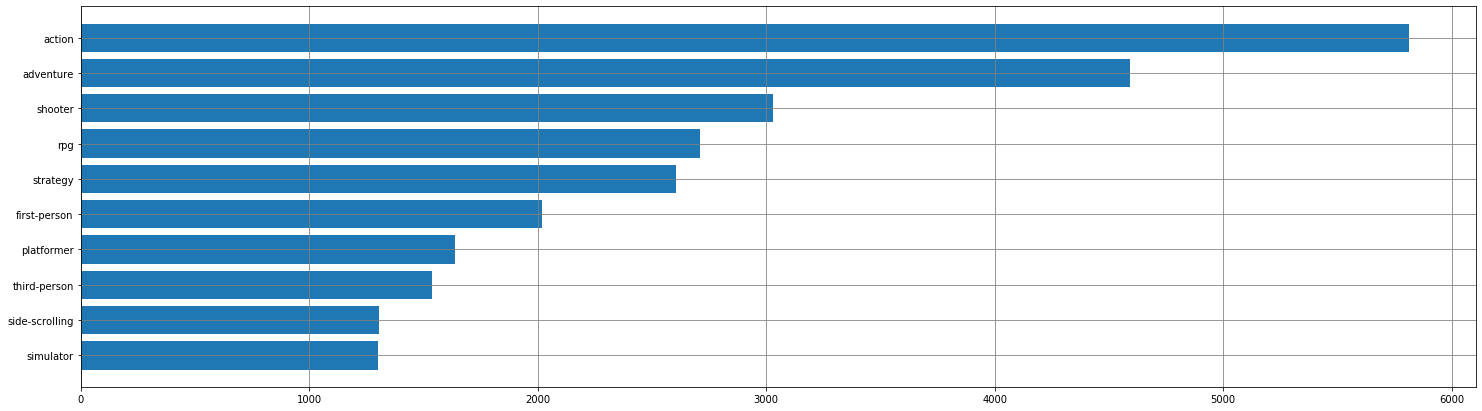

In [35]:
genres_df.sort_values(by='Counter', ascending=True, inplace=True)
plt.figure(figsize=(25, 7))
plt.grid(color='gray')
plt.barh(genres_df['Genres'][-10:], genres_df['Counter'][-10:])
plt.show()

As we can see most popular genres are action, shooter and adventure.

But which ones require more time to be completed? I'll add an average of the game's walkthrough and put it into a new dataframe.

In [0]:
list_temp = {}
for elem in genres:
    if data[data[elem] == 1].iloc[:, 0].count() != 0 and (data[data[elem] == 1]['Main Story Median'].mean()) > 1:
        list_temp[elem] = data[data[elem] == 1]['Main Story Median'].mean()


In [0]:

genres_walkthrough_time = pd.DataFrame(columns=['Genre', 'Avg_time'])
for key in sorted(list_temp.items(), key=lambda x: x[1], reverse=True):
    genres_walkthrough_time = genres_walkthrough_time.append({'Genre': key[0], 'Avg_time': key[1]}, ignore_index=True)

Time to plot a graph and see the results.

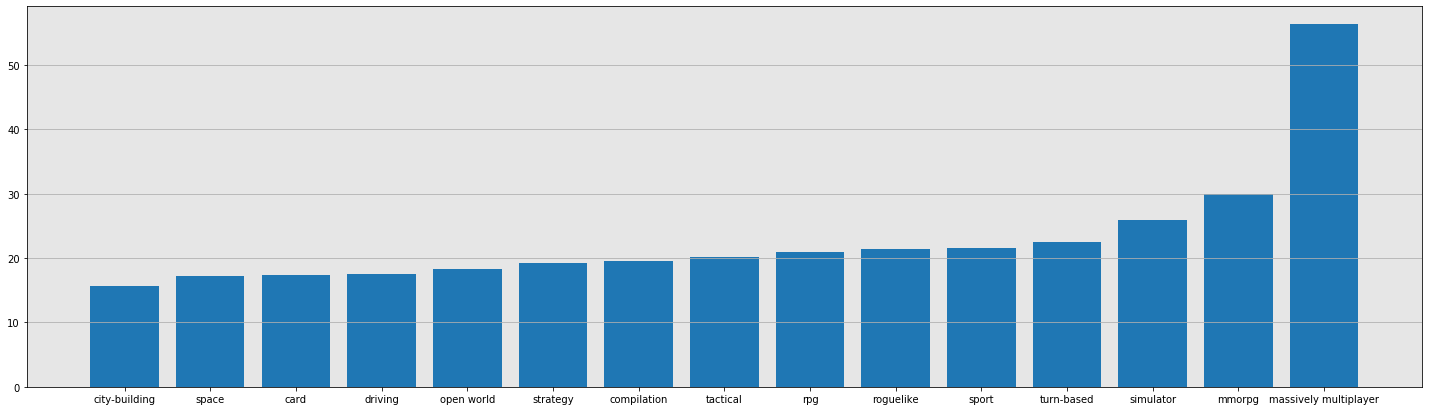

In [38]:
genres_walkthrough_time.sort_values(by='Avg_time', ascending=True, inplace=True)
plt.figure(figsize=(25, 7))
plt.axes(facecolor='#E6E6E6').yaxis.grid() 
plt.bar(genres_walkthrough_time['Genre'][-15:], genres_walkthrough_time['Avg_time'][-15:])
plt.show()

Of course, we can not trust information about MMO games, because they have not a single-player company. But in others, all are absolutely logical. RPGs required more time to complete than racings or shooters.

#### 2.4. Games overview

Before moving on to the part of machine learning,  it remains the last step - an overview of the game's data.

Let's see the difference between the median and an average value of AllPlayStyles' walkthrough.

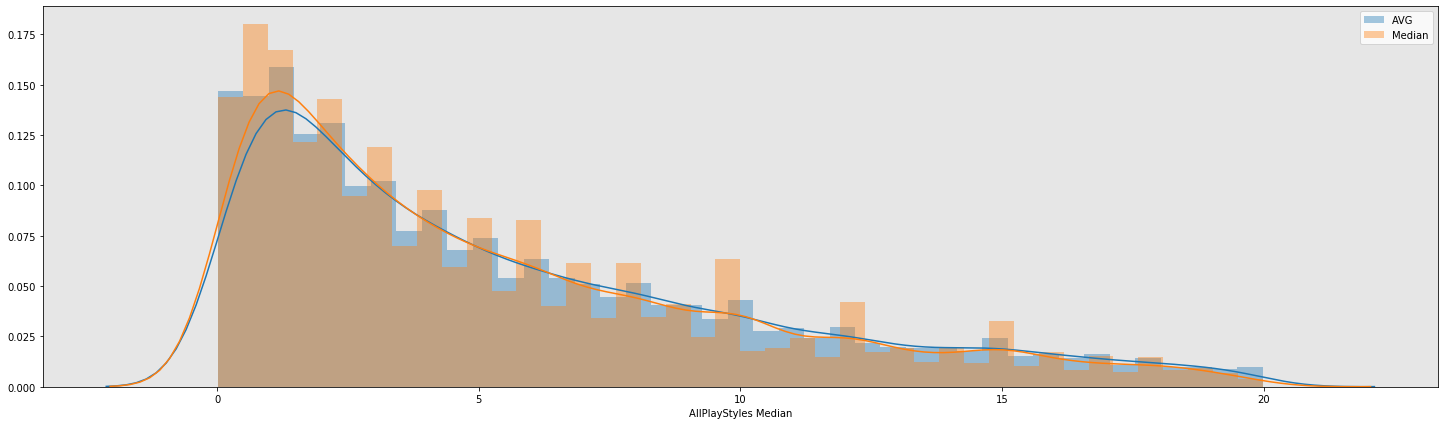

In [39]:
plt.figure(figsize=(25, 7))
plt.axes(facecolor='#E6E6E6')
sns.distplot(data[data['AllPlayStyles Average'] < 20]['AllPlayStyles Average'], label='AVG')
sns.distplot(data[data['AllPlayStyles Median'] < 20]['AllPlayStyles Median'], label='Median')
plt.legend()
plt.show()

As you can see, our distribution has positive skewness. And for short games, the median value is greater than average. This is possible because our dataset is not perfect and some games have problems with insufficient sample size (especially old games).

Now let's compare the average walkthrough's time by different playstyles.

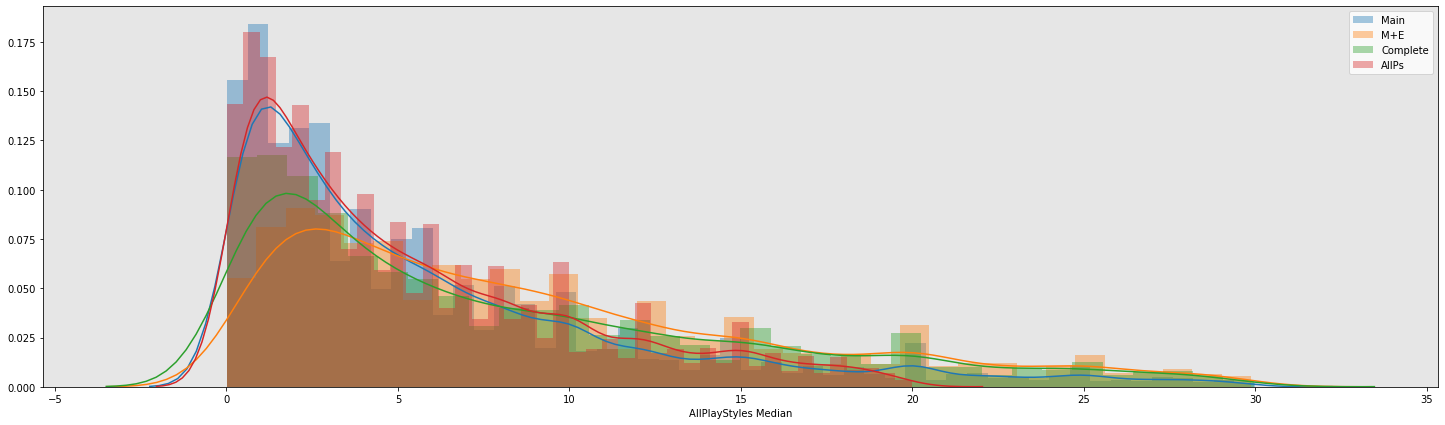

Main Story:	 8.940913060183805
Main + Extras:	 17.373437540910647
Completionists:	 23.686248321673272
AllPlayStyles:	 11.494424545807588


In [40]:
plt.figure(figsize=(25, 7))
plt.axes(facecolor='#E6E6E6')
sns.distplot(data[data['Main Story Median'] < 30]['Main Story Median'], label='Main')
sns.distplot(data[data['Main + Extras Median'] < 30]['Main + Extras Median'], label='M+E')
sns.distplot(data[data['Completionists Median'] < 30]['Completionists Median'], label='Complete')
sns.distplot(data[data['AllPlayStyles Median'] < 20]['AllPlayStyles Median'], label='AllPs')
plt.legend()
plt.show()
print('Main Story:\t', data['Main Story Median'].mean())
print('Main + Extras:\t', data['Main + Extras Median'].mean())
print('Completionists:\t', data['Completionists Median'].mean())
print('AllPlayStyles:\t', data['AllPlayStyles Median'].mean())

I'm not really sure, how 'AllPlayStyles' calculated, but it still amazing. To complete a game on 100% it needs 3 times more than just finish main scenario.

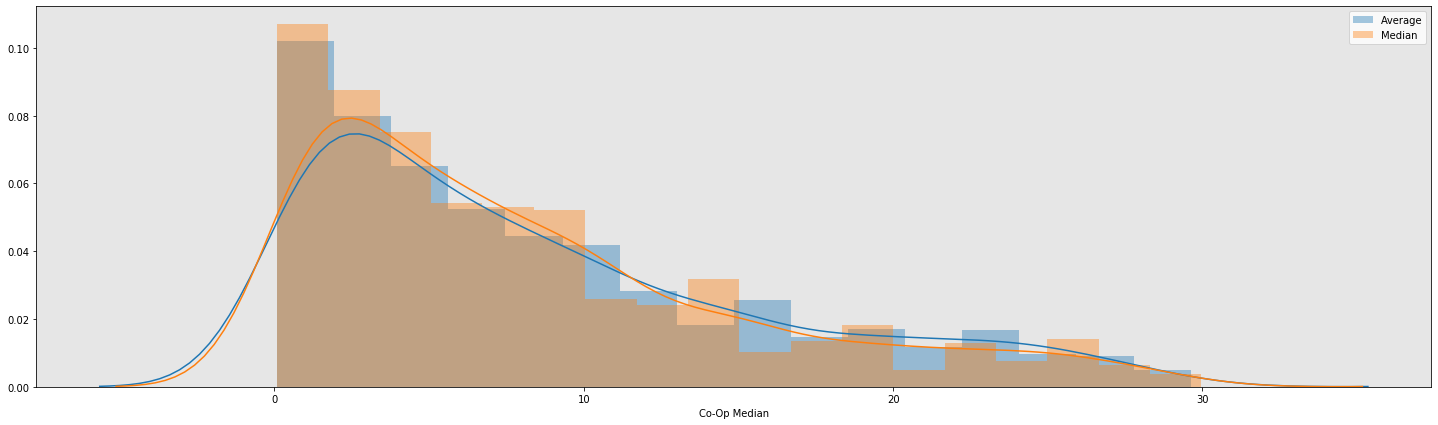

In [41]:
plt.figure(figsize=(25, 7))
plt.axes(facecolor='#E6E6E6')
sns.distplot(data[data['Co-Op Average'] < 30]['Co-Op Average'], label='Average')
sns.distplot(data[data['Co-Op Median'] < 30]['Co-Op Median'], label='Median')

plt.legend()
plt.show()

And last I want to see a statistic about the count of games released by year. Let's prepare the data.

In [0]:
year_time = data[['Released in NA', 'Main Story Median']]
year_time = year_time.reindex(range(0, len(year_time)))

In [43]:
indexes_list_temp = []
for i in range(0, len(year_time)):
    if (year_time.iloc[i, 0] != year_time.iloc[i, 0]) or (year_time.iloc[i, 1] != year_time.iloc[i, 1]):
        indexes_list_temp.append(i)


year_time.drop(indexes_list_temp, axis = 0, inplace=True)
year_time.reindex(range(0, len(year_time) - len(indexes_list_temp)))

,Released in NA,Main Story Median


In [0]:
for i in range(0, len(year_time)):
  if not (isinstance(year_time.iloc[i, 0], float)):
    year_time.iloc[i, 0] = year_time.iloc[i, 0][-4:]
  else:
    year_time.drop(i, axis = 0, inplace=True)

In [0]:
year_time = year_time.sort_values(by='Released in NA')

Now we have a df with year of release and median walkthrough in hours. How changed this value over the years?

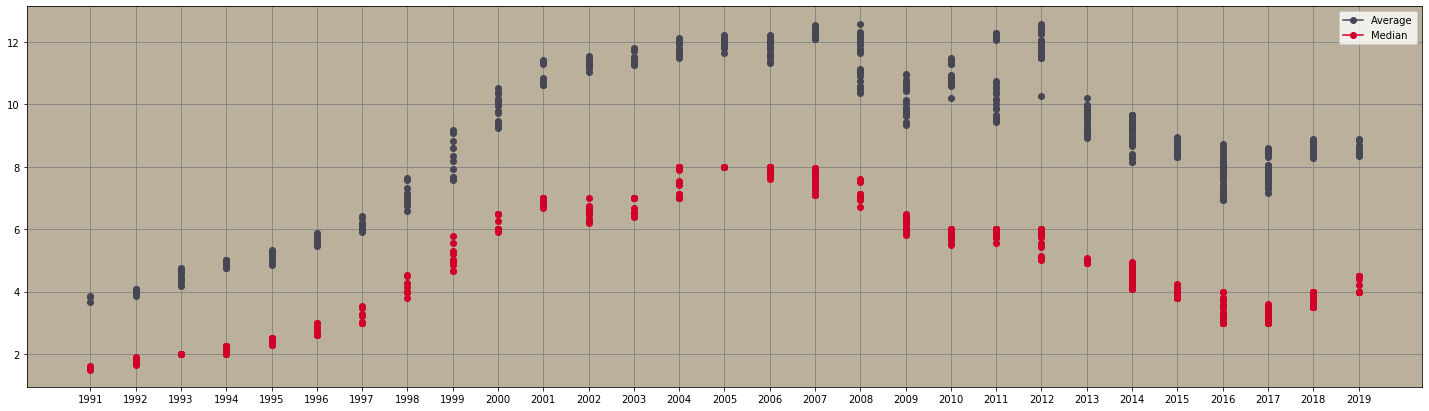

In [46]:
plt.figure(figsize=(25, 7))
plt.axes(facecolor='#BBB09B')
plt.grid(color='gray')
for i in range(1000, len(year_time), 25):
    y = year_time.iloc[i - 900:i, 1].mean()
    plt.plot(year_time.iloc[i, 0], y, marker='o', color='#464655')

    y = year_time.iloc[i - 900:i, 1].median()
    plt.plot(year_time.iloc[i, 0], y, marker='o', color='#D10029')
plt.legend(['Average', 'Median'])
plt.show()

Ok, we know, that average game's duration is larger than in 90 ', but the peak was in 2005-2012.

What about a number of released games by years?

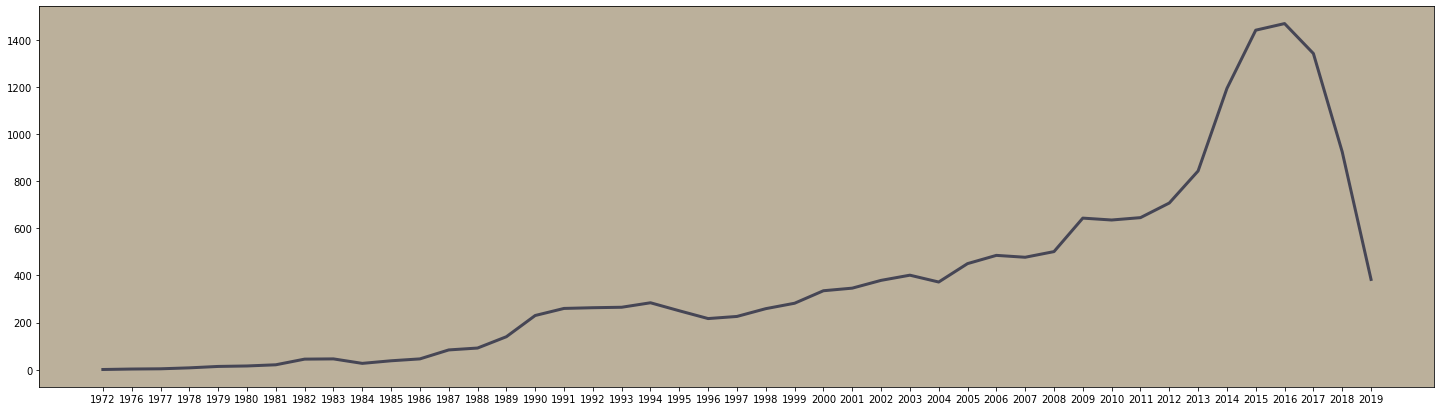

In [47]:
plt.figure(figsize=(25, 7))
plt.axes(facecolor='#BBB09B')
plt.plot(year_time['Released in NA'].unique(), year_time.groupby('Released in NA').count(), linewidth=3,
         color='#464655')

Yes, every year more and more games come. I can explain the decline in 2016-2019 only as the imperfection of the data.

### 3. Machine learning models
(temporarily unavailable)